In [1]:
import pandas as pd
from pandas import DataFrame, to_datetime
import numpy as np
import os
import datetime, time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import glob
import sqlite3
from typing import Union
from itertools import product
import pickle

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet import Prophet

C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Daten Import

In [3]:
# SQLite Datenbank Pfad 
SQLITE_FILE_PATH = os.path.join("..", "output", "dwh.sqlite3")

In [4]:
# Connection zur Datenbank 
con = sqlite3.connect(SQLITE_FILE_PATH)

## Marktstammdaten

In [5]:
# Datenbank-Abfrage
query_01 = """
SELECT *
FROM marktstammdaten_2023
"""
marktstammdaten = pd.read_sql_query(query_01, con=con)
marktstammdaten

,Inbetriebnahmedatum,AnlagenbetreiberMastrNummer,Bruttoleistung,Einspeisungsart,Lage
0,2000-01-01 00:00:00,ABR913047449452,4.800,Voll,853.0
1,2000-01-01 00:00:00,ABR927983195809,1.800,Voll,853.0
2,2000-01-01 00:00:00,ABR967497165592,3.600,Voll,853.0
3,2000-01-01 00:00:00,ABR995277554304,2.025,Voll,853.0
4,2000-01-01 00:00:00,ABR928317589493,4.500,Teil,853.0
...,...,...,...,...,...
3722262,2023-12-31 00:00:00,ABR932413982492,0.600,Teil,2961.0
3722263,2023-12-31 00:00:00,ABR976144407114,10.200,Teil,853.0
3722264,2023-12-31 00:00:00,ABR964771367109,0.800,Teil,2961.0
3722265,2023-12-31 00:00:00,ABR974622299794,0.780,Teil,2961.0


# Visualisierungen Marktstammdaten, Strompreise und EEG-Vergütung    
Aggregiert nach Monat/Jahr von 01/2000 bis 12/2023.

In [6]:
# Datenbank-Abfrage
query_02 = """
SELECT
    strftime('%Y-%m', m.Inbetriebnahmedatum) AS Jahr_Monat,
    SUM(CASE WHEN m.Einspeisungsart = 'Voll' THEN 1 ELSE 0 END) AS Anzahl_Volleinspeisung,
    SUM(CASE WHEN m.Einspeisungsart = 'Teil' THEN 1 ELSE 0 END) AS Anzahl_Teileinspeisung,
    AVG(e.Einspeiseverguetung_kleine_PV_Anlagen) AS Einspeiseverguetung,
    MAX(s.Strom_Verbraucherpreis) AS Strompreis
FROM
    marktstammdaten_2023 m
LEFT JOIN
    einspeiseverguetung e ON m.Inbetriebnahmedatum = e.Datum
LEFT JOIN
    strompreis s ON strftime('%Y', m.Inbetriebnahmedatum) = s.Jahr
GROUP BY
    strftime('%Y-%m', m.Inbetriebnahmedatum)
ORDER BY
    Jahr_Monat;
"""
eeg_strom_df = pd.read_sql_query(query_02, con=con)
eeg_strom_df

,Jahr_Monat,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis
0,2000-01,6944,2620,50.62,14.92
1,2000-02,99,25,50.62,14.92
2,2000-03,163,21,50.62,14.92
3,2000-04,871,153,50.62,14.92
4,2000-05,709,162,50.62,14.92
...,...,...,...,...,...
283,2023-08,3807,98267,7.65,46.27
284,2023-09,3443,89448,7.65,46.27
285,2023-10,3008,77553,7.65,46.27
286,2023-11,2221,66049,7.65,46.27


### Plot Voll-und Teileinspeisung (Monatsansicht)

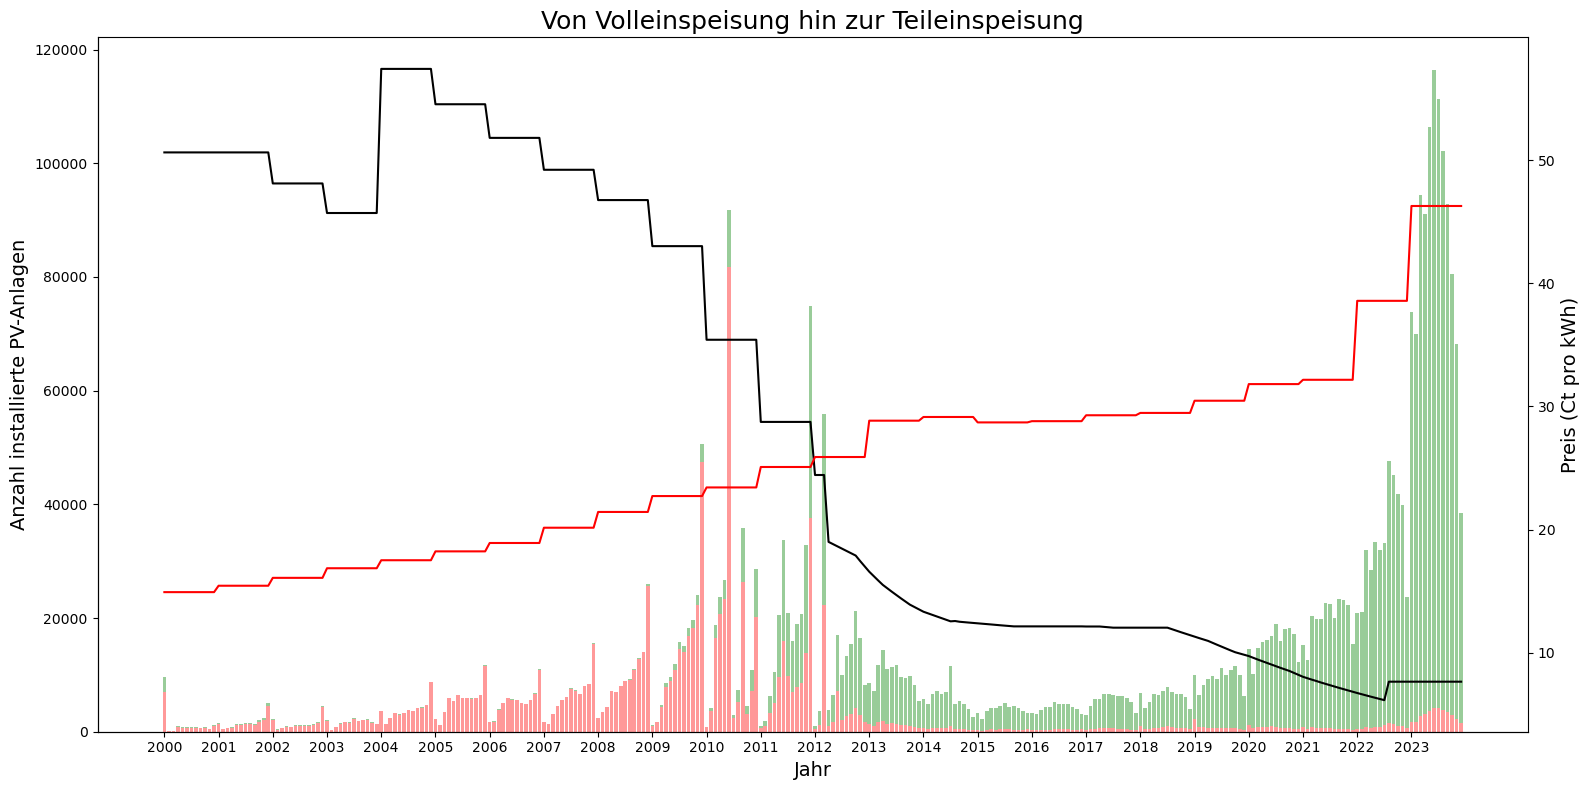

In [7]:
fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.bar(eeg_strom_df['Jahr_Monat'], eeg_strom_df['Anzahl_Volleinspeisung'], 
        label='Anzahl_Volleinspeisung', width=0.8, color='red', alpha=0.4)
ax1.bar(eeg_strom_df['Jahr_Monat'], eeg_strom_df['Anzahl_Teileinspeisung'], 
        label='Anzahl_Teileinspeisung', width=0.8, color='green', alpha=0.4, bottom=eeg_strom_df['Anzahl_Volleinspeisung'])

ax2 = ax1.twinx()
ax2.plot(eeg_strom_df['Jahr_Monat'], eeg_strom_df['Einspeiseverguetung'], color='black', label='Einspeisevergütung')
ax2.plot(eeg_strom_df['Jahr_Monat'], eeg_strom_df['Strompreis'], color='red', label='Strompreis')

plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

ax1.set_xlabel('Jahr', fontsize=14)
ax1.set_ylabel('Anzahl installierte PV-Anlagen', fontsize=14)
ax2.set_ylabel('Preis (Ct pro kWh)', fontsize=14)

years = eeg_strom_df['Jahr_Monat'].apply(lambda x: int(x[:4]))
positions = range(0, len(eeg_strom_df), 12)
plt.xticks(positions, years.unique(), rotation=45)

plt.title('Von Volleinspeisung hin zur Teileinspeisung', fontsize=18)
plt.tight_layout()

plt.show()


### Plot Voll-und Teileinspeisung (Jahresansicht)

In [8]:
# Jahr aus der Spalte Jahr_Monat extrahieren
eeg_strom_df['Jahr'] = eeg_strom_df['Jahr_Monat'].str[:4]

# numerische Werte
eeg_strom_df['Einspeiseverguetung'] = pd.to_numeric(eeg_strom_df['Einspeiseverguetung'], errors='coerce')
eeg_strom_df['Strompreis'] = pd.to_numeric(eeg_strom_df['Strompreis'], errors='coerce')

# nach Jahr gruppieren
eeg_strom_jahr = eeg_strom_df.groupby('Jahr').agg({
    'Anzahl_Volleinspeisung': 'sum',
    'Anzahl_Teileinspeisung': 'sum',
    'Einspeiseverguetung': 'mean',
    'Strompreis': 'mean'
})
eeg_strom_jahr.reset_index(inplace=True)
eeg_strom_jahr

,Jahr,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis
0,2000,13646,3739,50.620000,14.92
1,2001,17960,2332,50.620000,15.44
2,2002,15917,1484,48.100000,16.08
3,2003,19154,316,45.700000,16.86
4,2004,46396,320,57.400000,17.51
5,2005,66204,489,54.530000,18.23
6,2006,62810,526,51.800000,18.91
7,2007,75667,604,49.210000,20.15
8,2008,113687,999,46.750000,21.43
9,2009,167962,13253,43.010000,22.72


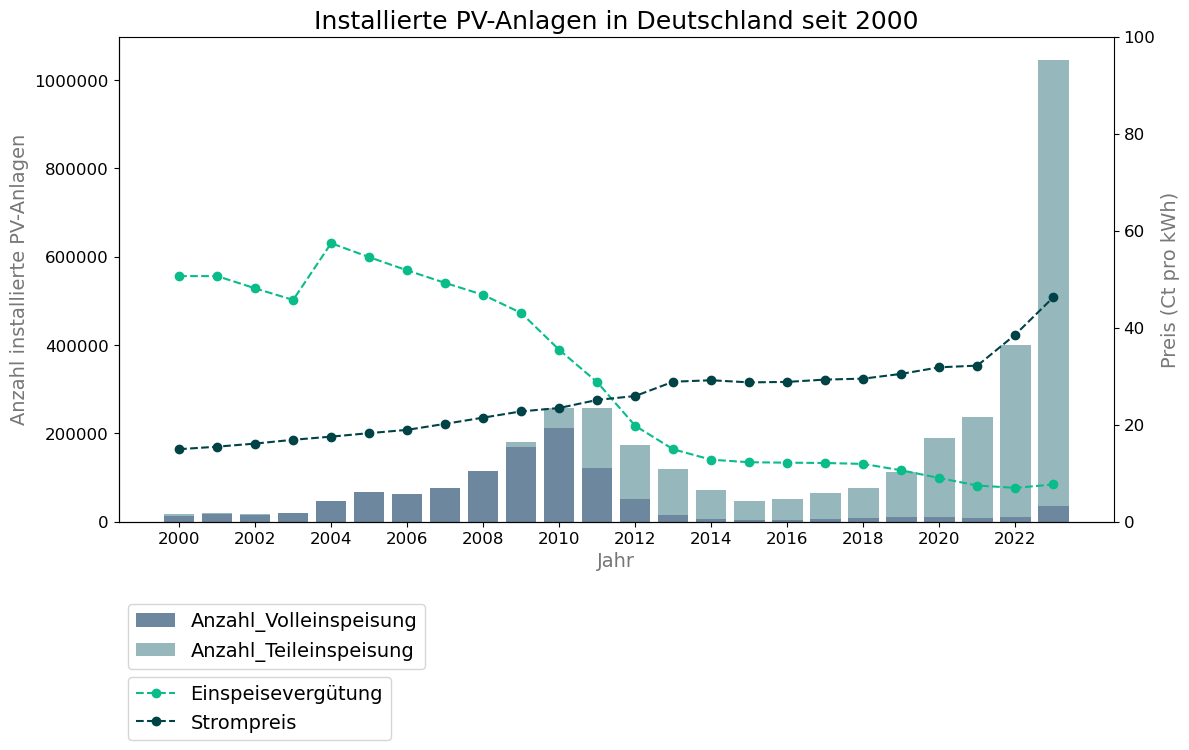

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(eeg_strom_jahr['Jahr'], eeg_strom_jahr['Anzahl_Volleinspeisung'], 
        label='Anzahl_Volleinspeisung', width=0.8, color='#2F5575', alpha=0.7)
ax1.bar(eeg_strom_jahr['Jahr'], eeg_strom_jahr['Anzahl_Teileinspeisung'], 
        label='Anzahl_Teileinspeisung', width=0.8, color='#508991', alpha=0.6, bottom=eeg_strom_jahr['Anzahl_Volleinspeisung'])

ax2 = ax1.twinx()
ax2.plot(eeg_strom_jahr['Jahr'], eeg_strom_jahr['Einspeiseverguetung'], color='#09bc8a', label='Einspeisevergütung', linestyle='--', marker='o')
ax2.plot(eeg_strom_jahr['Jahr'], eeg_strom_jahr['Strompreis'], color='#004346', label='Strompreis', linestyle='--', marker='o')

plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

ax1.set_xlabel('Jahr', fontsize=14, color='#777777')
ax1.set_ylabel('Anzahl installierte PV-Anlagen', fontsize=14, color='#777777')
ax1.ticklabel_format(style='plain', axis='y')  
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.set_ylabel('Preis (Ct pro kWh)', fontsize=14, color='#777777')
ax2.set_ylim([0, 100])
ax2.tick_params(axis='both', which='major', labelsize=12)

years = eeg_strom_jahr['Jahr']
positions = range(0, len(eeg_strom_jahr), 2) 
labels = [years[i] for i in positions] 
plt.xticks(positions, labels, rotation=45)  

# Legenden anzeigen
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, -0.15), ncol=1, fontsize=14) 
ax2.legend(loc='upper left', bbox_to_anchor=(0.0, -0.30), ncol=1, fontsize=14) 

plt.title('Installierte PV-Anlagen in Deutschland seit 2000', fontsize=18)
plt.tight_layout()

plt.show()

### Plot Installierte Gesamtleistung (Voll-und Teileinspeisung)

In [10]:
# Datenbank-Abfrage
query_03 = """
SELECT
    strftime('%Y-%m', m.Inbetriebnahmedatum) AS Jahr_Monat,
    SUM(CASE WHEN m.Einspeisungsart = 'Voll' THEN 1 ELSE 0 END) AS Anzahl_Volleinspeisung,
    SUM(CASE WHEN m.Einspeisungsart = 'Teil' THEN 1 ELSE 0 END) AS Anzahl_Teileinspeisung,
    AVG(e.Einspeiseverguetung_kleine_PV_Anlagen) AS Einspeiseverguetung,
    MAX(s.Strom_Verbraucherpreis) AS Strompreis,
    SUM(CASE WHEN m.Einspeisungsart = 'Voll' THEN m.Bruttoleistung ELSE 0 END) AS Bruttoleistung_Volleinspeisung,
    SUM(CASE WHEN m.Einspeisungsart = 'Teil' THEN m.Bruttoleistung ELSE 0 END) AS Bruttoleistung_Teileinspeisung,
    SUM(SUM(m.Bruttoleistung)) OVER (ORDER BY strftime('%Y-%m', m.Inbetriebnahmedatum) ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS Kumulierte_Bruttoleistung
FROM
    marktstammdaten_2023 m
LEFT JOIN
    einspeiseverguetung e ON m.Inbetriebnahmedatum = e.Datum
LEFT JOIN
    strompreis s ON strftime('%Y', m.Inbetriebnahmedatum) = s.Jahr
GROUP BY
    Jahr_Monat
ORDER BY
    strftime('%Y-%m', m.Inbetriebnahmedatum);

"""
leistung_df = pd.read_sql_query(query_03, con=con)
leistung_df

,Jahr_Monat,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,Bruttoleistung_Volleinspeisung,Bruttoleistung_Teileinspeisung,Kumulierte_Bruttoleistung
0,2000-01,6944,2620,50.62,14.92,28055.549,14253.348,4.230890e+04
1,2000-02,99,25,50.62,14.92,688.311,69.438,4.306665e+04
2,2000-03,163,21,50.62,14.92,621.903,76.260,4.376481e+04
3,2000-04,871,153,50.62,14.92,2943.588,536.377,4.724477e+04
4,2000-05,709,162,50.62,14.92,2698.850,586.165,5.052979e+04
...,...,...,...,...,...,...,...,...
283,2023-08,3807,98267,7.65,46.27,1227021.874,1077068.493,8.109376e+07
284,2023-09,3443,89448,7.65,46.27,321366.880,1037490.499,8.245262e+07
285,2023-10,3008,77553,7.65,46.27,1185349.079,915837.751,8.455380e+07
286,2023-11,2221,66049,7.65,46.27,757073.381,823964.660,8.613484e+07


In [11]:
# Jahr aus der Spalte Jahr_Monat extrahieren
leistung_df['Jahr_Monat'] = pd.to_datetime(leistung_df['Jahr_Monat'])

# Aggregieren auf Jahresbasis
leistung_agg = leistung_df.groupby(leistung_df['Jahr_Monat'].dt.year).agg({
    'Anzahl_Volleinspeisung': 'sum',
    'Anzahl_Teileinspeisung': 'sum',
    'Kumulierte_Bruttoleistung': 'last' 
}).reset_index()

In [12]:
leistung_agg

,Jahr_Monat,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Kumulierte_Bruttoleistung
0,2000,13646,3739,7.440135e+04
1,2001,17960,2332,1.689582e+05
2,2002,15917,1484,2.738236e+05
3,2003,19154,316,4.168361e+05
4,2004,46396,320,1.065612e+06
5,2005,66204,489,1.985568e+06
6,2006,62810,526,2.824679e+06
7,2007,75667,604,4.069579e+06
8,2008,113687,999,6.037020e+06
9,2009,167962,13253,1.045883e+07


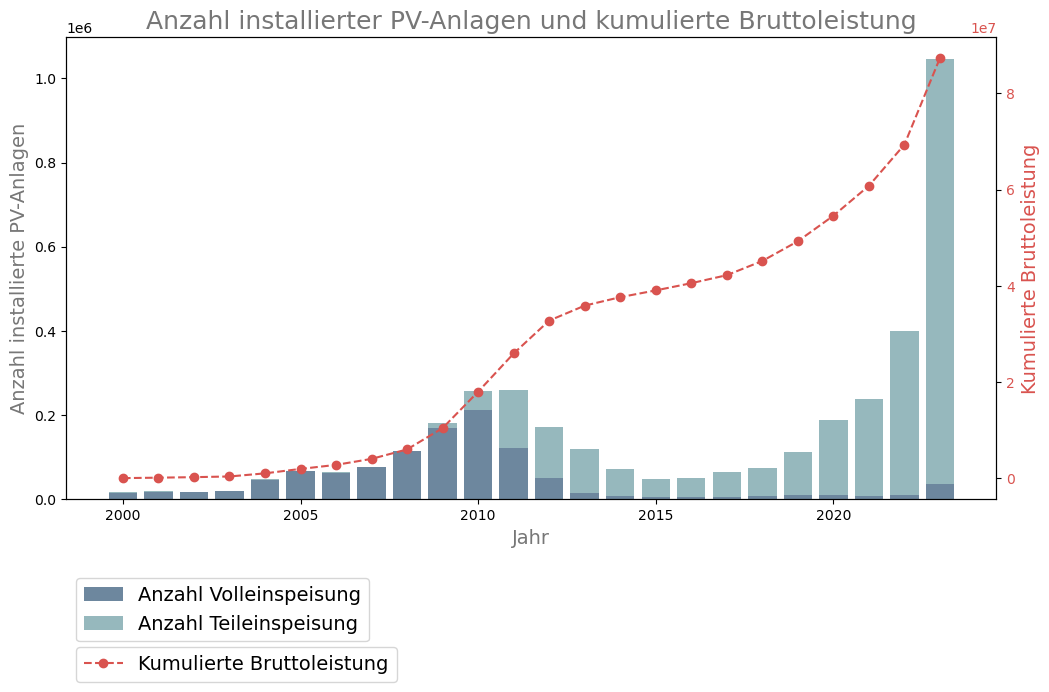

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(leistung_agg['Jahr_Monat'], leistung_agg['Anzahl_Volleinspeisung'], label='Anzahl Volleinspeisung', alpha=0.7, color='#2F5575')
ax1.bar(leistung_agg['Jahr_Monat'], leistung_agg['Anzahl_Teileinspeisung'], label='Anzahl Teileinspeisung', alpha=0.6, color='#508991', bottom=eeg_strom_jahr['Anzahl_Volleinspeisung'])

ax1.set_xlabel('Jahr', fontsize=14, color='#777777')
ax1.set_ylabel('Anzahl installierte PV-Anlagen', fontsize=14, color='#777777')
ax1.legend(loc='upper left', fontsize=12)

ax2 = ax1.twinx()
ax2.plot(leistung_agg['Jahr_Monat'], leistung_agg['Kumulierte_Bruttoleistung'], color='#D9534F', label='Kumulierte Bruttoleistung', linestyle='--', marker='o')

ax2.set_ylabel('Kumulierte Bruttoleistung', color='#D9534F', fontsize=14)
ax2.tick_params(axis='y', labelcolor='#D9534F')
ax2.legend(loc='upper right', fontsize=12)

ax1.legend(loc='upper left', bbox_to_anchor=(0.0, -0.15), ncol=1, fontsize=14) 
ax2.legend(loc='upper left', bbox_to_anchor=(0.0, -0.30), ncol=1, fontsize=14) 

plt.title('Anzahl installierter PV-Anlagen und kumulierte Bruttoleistung', fontsize=18, color='#777777')
plt.show()

### Plot Installierte Gesamtleistung pro Monat vs. Entwicklung Einspeisevergütung und Strompreis

In [14]:
leistung_agg2 = leistung_df.groupby(leistung_df['Jahr_Monat'].dt.year).agg({
    'Einspeiseverguetung': 'last',  
    'Strompreis': 'last',
    'Bruttoleistung_Volleinspeisung': 'sum',
    'Bruttoleistung_Teileinspeisung': 'sum'
}).reset_index()

leistung_agg2['Gesamt_Bruttoleistung'] = leistung_agg2['Bruttoleistung_Volleinspeisung'] + leistung_agg2['Bruttoleistung_Teileinspeisung']

In [15]:
leistung_agg2

,Jahr_Monat,Einspeiseverguetung,Strompreis,Bruttoleistung_Volleinspeisung,Bruttoleistung_Teileinspeisung,Gesamt_Bruttoleistung
0,2000,50.620,14.92,55314.525,1.908682e+04,7.440135e+04
1,2001,50.620,15.44,84126.132,1.043074e+04,9.455687e+04
2,2002,48.100,16.08,97535.504,7.329901e+03,1.048654e+05
3,2003,45.700,16.86,141283.024,1.729491e+03,1.430125e+05
4,2004,57.400,17.51,644987.773,3.788485e+03,6.487763e+05
5,2005,54.530,18.23,908860.585,1.109527e+04,9.199559e+05
6,2006,51.800,18.91,832062.970,7.047976e+03,8.391109e+05
7,2007,49.210,20.15,1232155.604,1.274459e+04,1.244900e+06
8,2008,46.750,21.43,1915163.733,5.227671e+04,1.967440e+06
9,2009,43.010,22.72,4243661.560,1.781470e+05,4.421809e+06


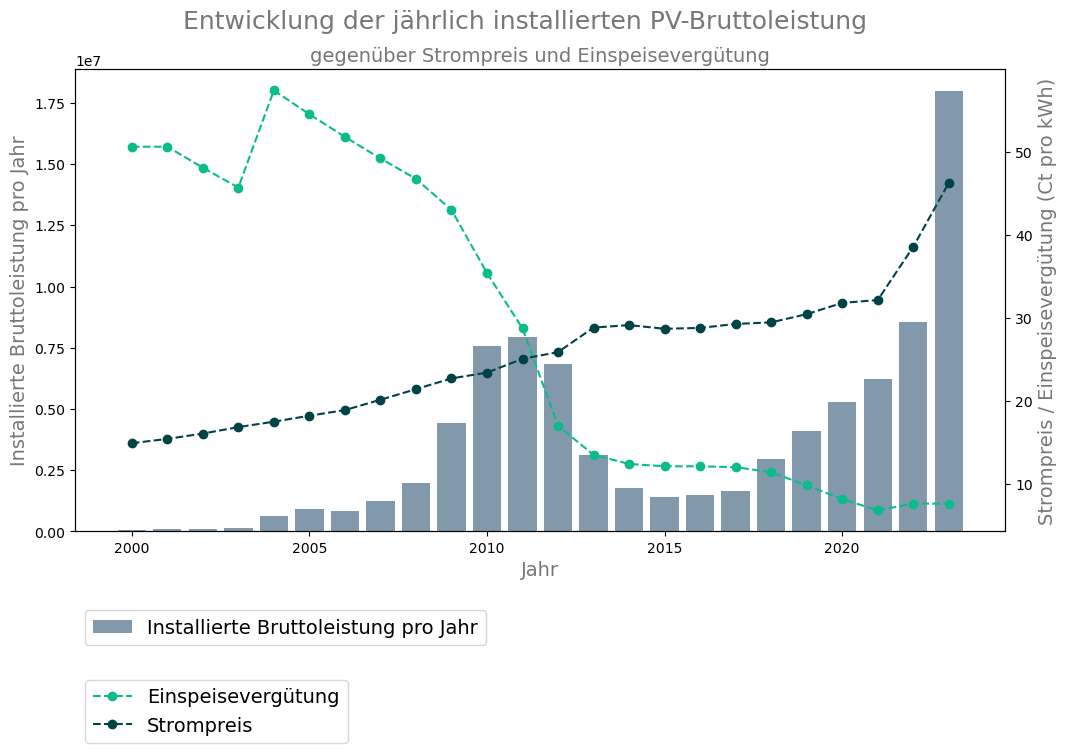

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Balken für Gesamt-Bruttoleistung auf ax1
ax1.bar(leistung_agg2['Jahr_Monat'], leistung_agg2['Gesamt_Bruttoleistung'], label='Installierte Bruttoleistung pro Jahr', alpha=0.6, color='#2F5575', width=0.8)

# Linien für Einspeisevergütung und Strompreis auf ax2
ax2 = ax1.twinx()
ax2.plot(leistung_agg2['Jahr_Monat'], leistung_agg2['Einspeiseverguetung'], color='#09bc8a', label='Einspeisevergütung', linestyle='--', marker='o')
ax2.plot(leistung_agg2['Jahr_Monat'], leistung_agg2['Strompreis'], color='#004346', label='Strompreis', linestyle='--', marker='o')

# Achsenbeschriftungen und Legenden
ax1.set_xlabel('Jahr', fontsize=14, color='#777777')
ax1.set_ylabel('Installierte Bruttoleistung pro Jahr', fontsize=14, color='#777777')
ax2.set_ylabel('Strompreis / Einspeisevergütung (Ct pro kWh)', fontsize=14, color='#777777')


# Legenden anzeigen
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, -0.15), ncol=1, fontsize=14) 
ax2.legend(loc='upper left', bbox_to_anchor=(0.0, -0.30), ncol=1, fontsize=14) 

# Titel und Anzeige
plt.suptitle('Entwicklung der jährlich installierten PV-Bruttoleistung', fontsize=18, color='#777777')
plt.title('gegenüber Strompreis und Einspeisevergütung', fontsize=14, color='#777777')

ax1.set_ylim(bottom=0)
plt.show()

# Zeitreihen-Analyse & Modell Evaluation   
Techniken zur Zeitreihen-Analyse: https://levelup.gitconnected.com/mastering-time-series-analysis-from-scratch-a-data-scientists-roadmap-437ff673df72     

## Einlesen der Daten

In [17]:
# Datenbank-Abfrage
query_04 = """
SELECT
    strftime('%Y-%m', m.Inbetriebnahmedatum) AS Jahr_Monat,
    SUM(m.Bruttoleistung) AS GesamtBruttoleistung,
    SUM(CASE WHEN m.Einspeisungsart = 'Voll' THEN 1 ELSE 0 END) AS Anzahl_Volleinspeisung,
    SUM(CASE WHEN m.Einspeisungsart = 'Teil' THEN 1 ELSE 0 END) AS Anzahl_Teileinspeisung,
    AVG(e.Einspeiseverguetung_kleine_PV_Anlagen) AS Einspeiseverguetung,
    MAX(s.Strom_Verbraucherpreis) AS Strompreis

FROM
    marktstammdaten_2023 m
LEFT JOIN
    einspeiseverguetung e ON m.Inbetriebnahmedatum = e.Datum
LEFT JOIN
    strompreis s ON strftime('%Y', m.Inbetriebnahmedatum) = s.Jahr
GROUP BY
    Jahr_Monat
ORDER BY
    strftime('%Y-%m', m.Inbetriebnahmedatum);
"""
timeseries_df1 = pd.read_sql_query(query_04, con=con)
#timeseries_df1

In [18]:
# Datenbank-Abfrage
query_05 = """
SELECT
    p.Jahr_Monat,
    p.PV_Kosten_Euro_pro_kWp,
    e.Fukushima,
    e.Ukrainekrieg,
    e.Solardeckel
FROM
    pv_kosten p
LEFT JOIN
    ereignisse e ON p.Jahr_Monat = e.Datum;
    
"""
timeseries_df2 = pd.read_sql_query(query_05, con=con)
#timeseries_df2

In [19]:
timeseries_df1['Jahr_Monat'] = pd.to_datetime(timeseries_df1['Jahr_Monat'], errors='coerce')
timeseries_df2['Jahr_Monat'] = pd.to_datetime(timeseries_df2['Jahr_Monat'], errors='coerce')
timeseries_df = pd.merge(timeseries_df1, timeseries_df2, on='Jahr_Monat', how='left')
timeseries_df = timeseries_df.fillna(0)
timeseries_df = timeseries_df.set_index('Jahr_Monat')
timeseries_df.index.freq = 'MS'
timeseries_df

,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,PV_Kosten_Euro_pro_kWp,Fukushima,Ukrainekrieg,Solardeckel
Jahr_Monat,,,,,,,,,
2000-01-01,42308.897,6944,2620,50.62,14.92,8100,0,0,0
2000-02-01,757.749,99,25,50.62,14.92,8100,0,0,0
2000-03-01,698.163,163,21,50.62,14.92,8100,0,0,0
2000-04-01,3479.965,871,153,50.62,14.92,8100,0,0,0
2000-05-01,3285.015,709,162,50.62,14.92,8100,0,0,0
...,...,...,...,...,...,...,...,...,...
2023-08-01,2304090.367,3807,98267,7.65,46.27,1250,0,0,0
2023-09-01,1358857.379,3443,89448,7.65,46.27,1250,0,0,0
2023-10-01,2101186.830,3008,77553,7.65,46.27,1250,0,0,0


In [20]:
#Tabelle speichern als pickle
timeseries_df.to_pickle('timeseries_df.pkl')

In [21]:
# als Pickle gespeicherte Tabelle öffnen

#with open('timeseries_df.pkl', 'rb') as f:
#    timeseries_df = pickle.load(f)
#timeseries_df

## Explorative Datenanalyse

### Basis Statistik

In [22]:
timeseries_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
GesamtBruttoleistung,288.0,303115.826847,466178.058105,698.163,49112.28375,138104.5175,375070.60775,3593625.28
Anzahl_Volleinspeisung,288.0,3817.486111,7324.880406,99.000,640.25000,1204.0000,4248.50000,81800.00
Anzahl_Teileinspeisung,288.0,9107.052083,18216.725187,7.000,73.75000,3394.0000,9460.75000,112128.00
Einspeiseverguetung,288.0,29.131580,18.706612,6.150,12.03500,26.5850,48.37750,57.40
Strompreis,288.0,25.422500,7.597861,14.920,18.74000,25.4850,29.32750,46.27
PV_Kosten_Euro_pro_kWp,288.0,3620.833333,2244.152293,1250.000,1562.50000,2600.0000,5425.00000,8100.00
Fukushima,288.0,0.034722,0.183394,0.000,0.00000,0.0000,0.00000,1.00
Ukrainekrieg,288.0,0.020833,0.143075,0.000,0.00000,0.0000,0.00000,1.00
Solardeckel,288.0,0.336806,0.473440,0.000,0.00000,0.0000,1.00000,1.00


### Visualisierung der Zeitreihen

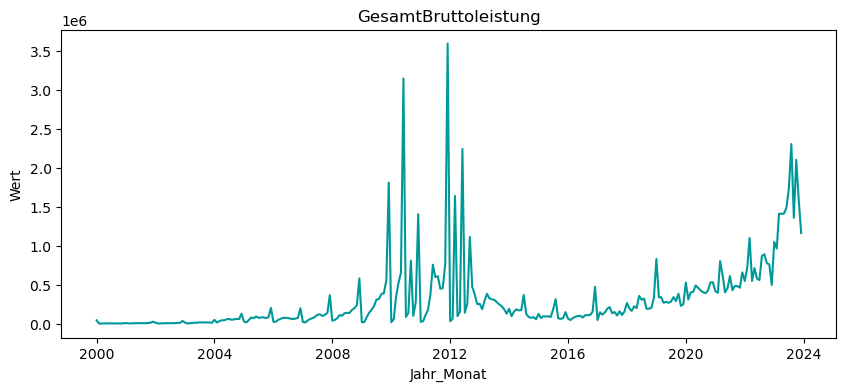

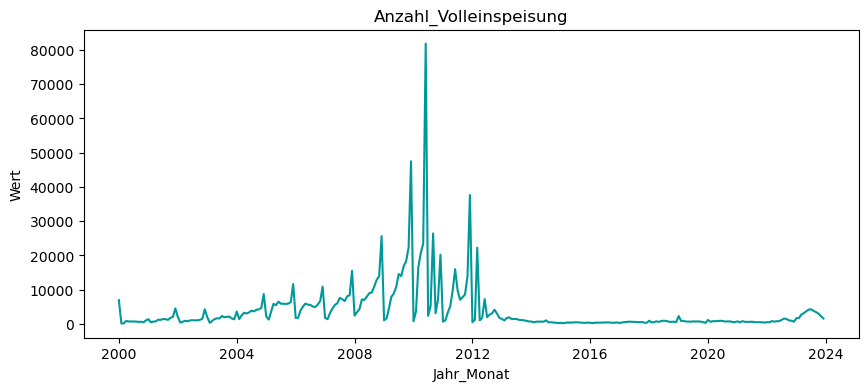

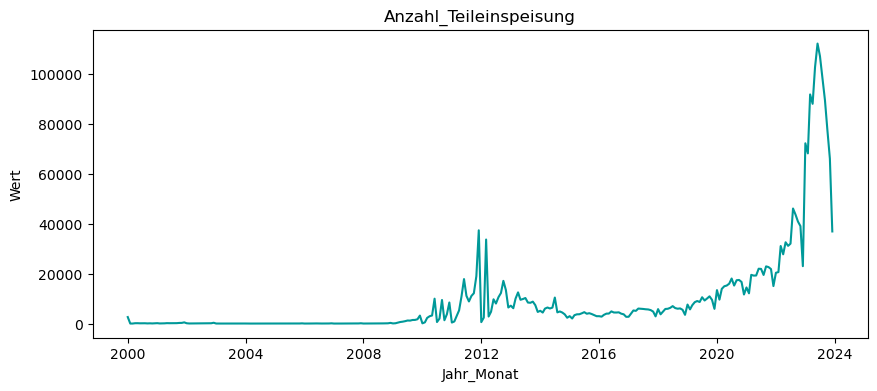

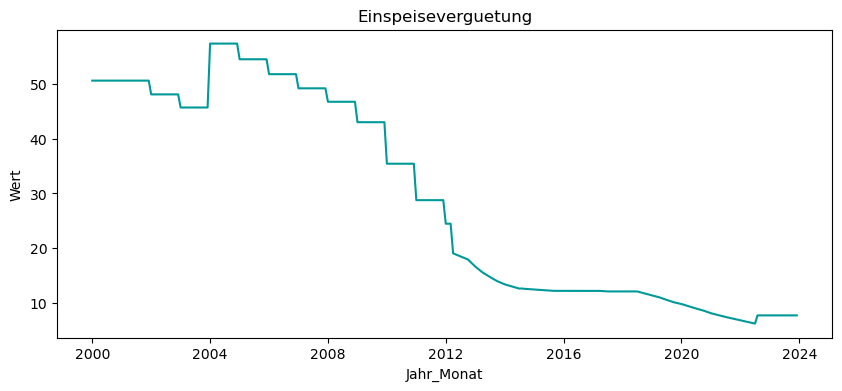

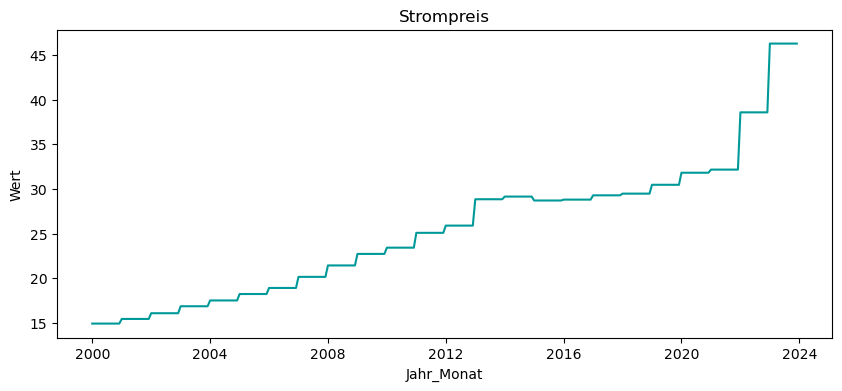

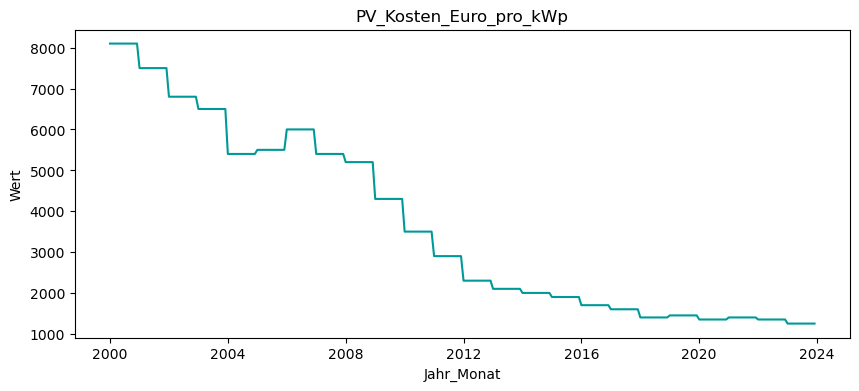

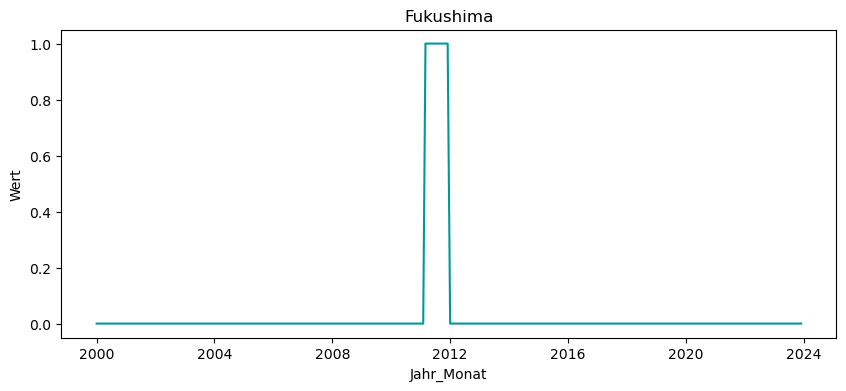

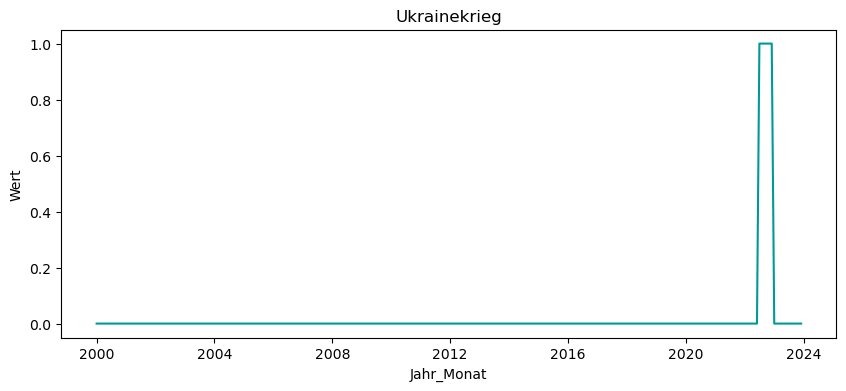

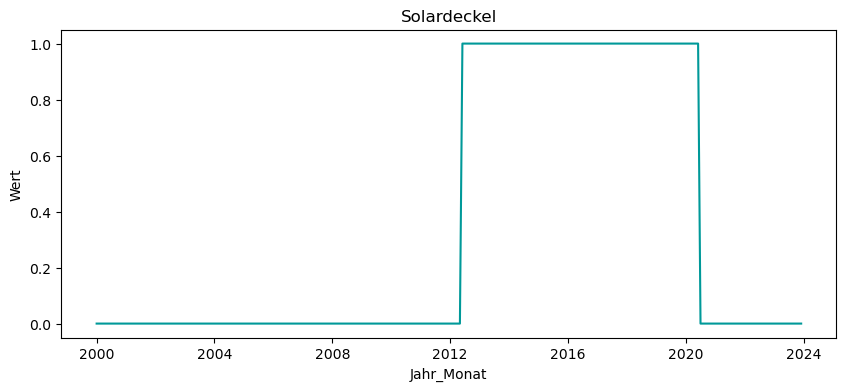

In [23]:
for column in timeseries_df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(timeseries_df.index, timeseries_df[column], color='#009999')
    
    plt.title(column)
    plt.xlabel('Jahr_Monat')
    plt.ylabel('Wert')
    
    plt.show()

### Korrelationsmatrix

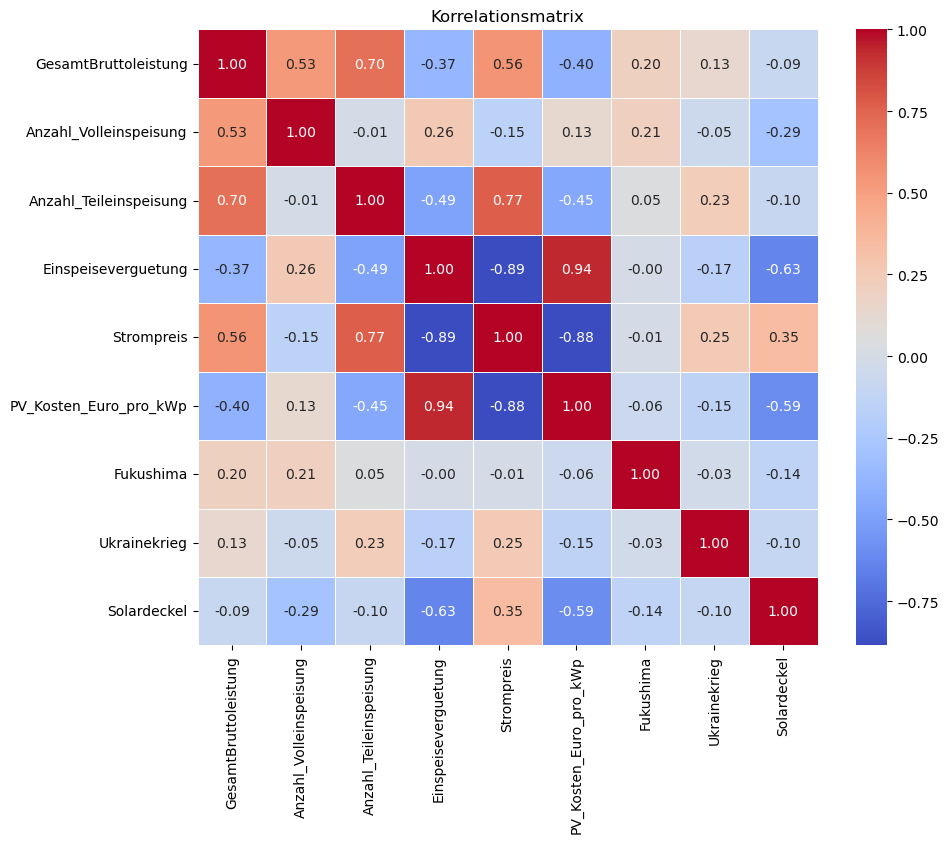

In [24]:
correlation_matrix = timeseries_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Korrelationsmatrix')
plt.show()

### Time Series Decomposition    
Saisonalität, Trend und Residuen    
Quellen:   
https://medium.com/@hadiamubashar/understanding-time-series-analysis-a-comprehensive-guide-f3b067350f07    
https://towardsdatascience.com/time-series-analysis-with-statsmodels-12309890539a     
Time Series Forecasting in Python by Marco Peixeiro (Manning Publications Co. LLC, 2022)   

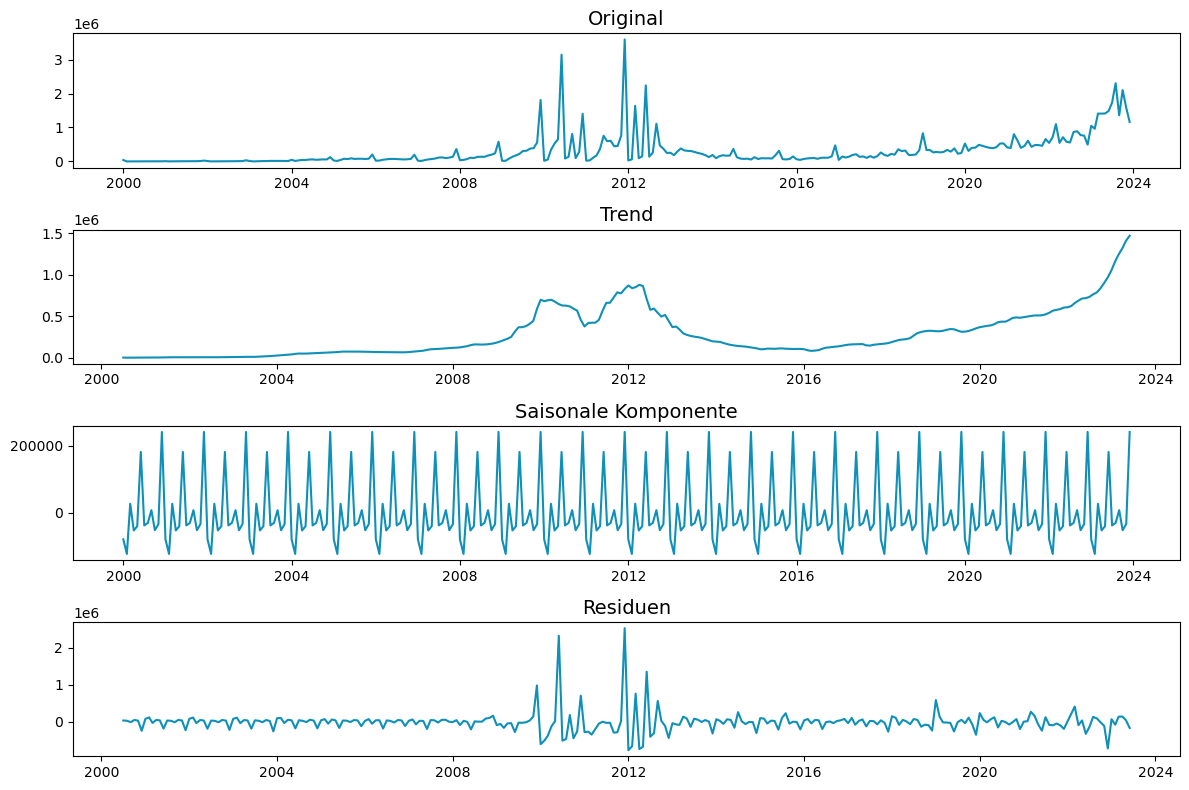

In [25]:
# Saisonale Zerlegung
result = seasonal_decompose(timeseries_df['GesamtBruttoleistung'], period=12) 

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed, color='#0E90B8')
plt.title('Original', fontsize=14)

plt.subplot(4, 1, 2)
plt.plot(result.trend, color='#0E90B8')
plt.title('Trend', fontsize=14)

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, color='#0E90B8')
plt.title('Saisonale Komponente', fontsize=14)

plt.subplot(4, 1, 4)
plt.plot(result.resid, color='#0E90B8')
plt.title('Residuen', fontsize=14)

plt.tight_layout()
plt.show()

**Ergebnisse:**    
Der erste Plot zeigt die Entwicklung der Zielvariablen *GesamtBruttoleistung* über die Zeit.   
Im zweiten Plot ist der Trend dargestellt. Bis 2010 ist ein positiver Trend zu beobachten. Zwischen 2011 und 2013 ist eine starke Entwicklung zu sehen, die ab 2013 an Dynamik verliert und zu sinkenden Werten führt. Erst ab 2016 ist wieder ein positiver Trend erkennbar, der zwischen 2022 und 2023 nochmals deutlich ansteigt.    
Das sich jährlich wiederholende Muster im dritten Plot zeigt eine saisonale Komponente mit Peaks in der Jahresmitte und gegen Ende des Jahres.    
Im letzten Diagramm sind die Residuen dargestellt. Sie zeigen die Abweichungen in den Daten, die nicht durch Trend und Saisonale Effekte erklärt werden können.

### Visualisierung der Verteilung der Variablen

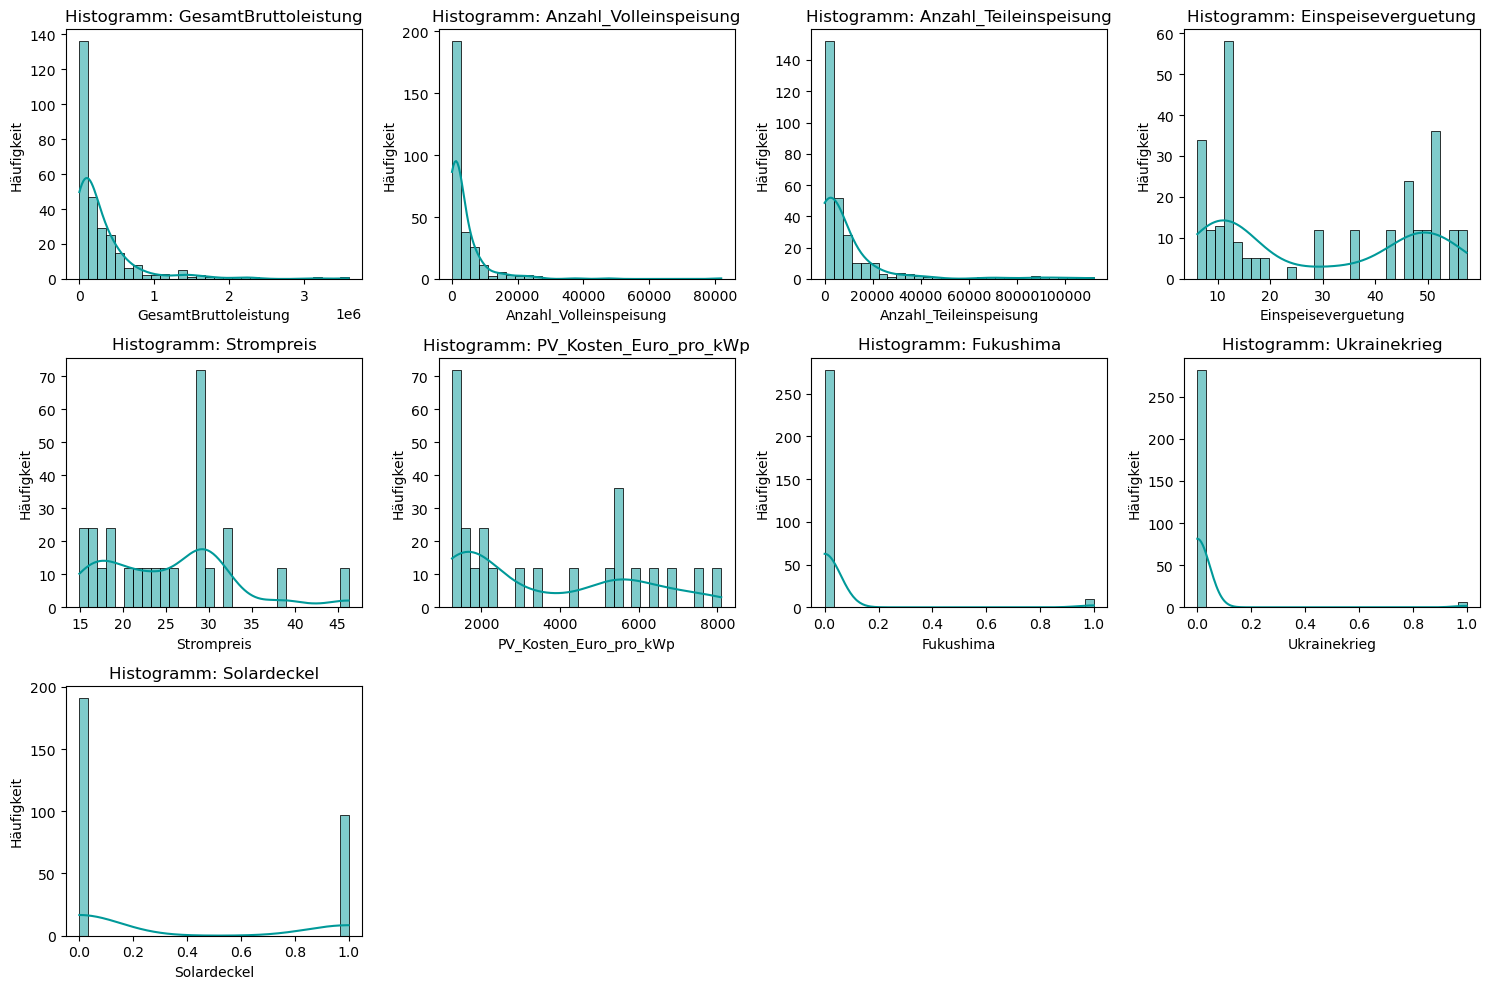

In [26]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(timeseries_df.columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(timeseries_df[column], bins=30, kde=True, color='#009999')
    plt.title(f'Histogramm: {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')

plt.tight_layout()
plt.show()

### Test auf Stationarität der Zeitreihe   
Dickey-Fuller-Test (ADF-Test)   
Quellen:    
Time Series Forecasting in Python by Marco Peixeiro (Manning Publications Co. LLC, 2022), S. 47-50 und 135    
https://levelup.gitconnected.com/mastering-time-series-analysis-from-scratch-a-data-scientists-roadmap-437ff673df72    
    
Eine Zeitreihe wird als stationär bezeichnet, wenn sich ihr Mittelwert, ihre Varianz und ihre Autokorrelation im Laufe der Zeit nicht ändern. Viele Modelle können nur verwendet werden, wenn die Daten tatsächlich stationär sind. Andernfalls werden die Modelle ungültig und die Prognosen unuverlässig.   

In [27]:
timeseries_diff = pd.DataFrame()

for column in timeseries_df.columns:
    result = adfuller(timeseries_df[column].dropna())
    
    # Prüfen auf Stationarität
    if result[1] >= 0.05:  
        # Wenn der p-Wert größer oder gleich 0.05 ist, differenzieren der Zeitreihe
        timeseries_diff[column + '_diff'] = timeseries_df[column].diff()
        
        # ADF-Test für die differenzierte Zeitreihe
        result_diff = adfuller(timeseries_diff[column + '_diff'].dropna())
        
        print(f'Variable: {column}')
        print('ADF-Statistik nach Differenzierung:', result_diff[0])
        print('p-Wert nach Differenzierung:', result_diff[1])
        print('Stationär nach Differenzierung?' , 'Ja' if result_diff[1] < 0.05 else 'Nein')
        print('\n')

Variable: GesamtBruttoleistung
ADF-Statistik nach Differenzierung: -6.148692453769714
p-Wert nach Differenzierung: 7.655418037749908e-08
Stationär nach Differenzierung? Ja


Variable: Anzahl_Volleinspeisung
ADF-Statistik nach Differenzierung: -7.054118018200767
p-Wert nach Differenzierung: 5.430730251110075e-10
Stationär nach Differenzierung? Ja


Variable: Anzahl_Teileinspeisung
ADF-Statistik nach Differenzierung: -3.49604950572977
p-Wert nach Differenzierung: 0.008089132651306268
Stationär nach Differenzierung? Ja


Variable: Einspeiseverguetung
ADF-Statistik nach Differenzierung: -17.00815678413235
p-Wert nach Differenzierung: 8.630334480294099e-30
Stationär nach Differenzierung? Ja


Variable: Strompreis
ADF-Statistik nach Differenzierung: -0.4608668070189845
p-Wert nach Differenzierung: 0.8994295162666537
Stationär nach Differenzierung? Nein


Variable: PV_Kosten_Euro_pro_kWp
ADF-Statistik nach Differenzierung: -3.3635100202312027
p-Wert nach Differenzierung: 0.012267519914822514


In [28]:
timeseries_diff['Strompreis_diff_2'] = timeseries_diff['Strompreis_diff'].diff()

print('ADF-Statistik nach Differenzierung:', result_diff[0])
print('p-Wert nach Differenzierung:', result_diff[1])
print('Stationär nach der 2. Differenzierung?' , 'Ja' if result_diff[1] < 0.05 else 'Nein')
print('\n')

ADF-Statistik nach Differenzierung: -16.852299546352718
p-Wert nach Differenzierung: 1.1162141769155096e-29
Stationär nach der 2. Differenzierung? Ja




**Ergebnis:**    
Fast alle Variablen erreichen nach der ersten Differenzierung Stationarität. Lediglich für *Strompreis* ist eine zweite Differenzierung notwendig. Die Variable *Fukushima' ist bereits stationät. Stationarität bedeutet, dass unabhängig von zeitlichen Faktoren statistische Eigenschaften, wie  der mittlere Erwartungswert und die Varianz konstant bleiben. (d=2)

### Test auf Autokorrelation   
Quellen:        
Time Series Forecasting in Python by Marco Peixeiro (Manning Publications Co. LLC, 2022), S. 50-53   
   
Autokorrelation misst die Korrelation zwischen einer Variablen und sich selbst zu einem früheren Zeitschritt (Lag). Die Autokorrelationsfunktion (ACF) zeigt, wie sich die Autokorrelation in Abhängigkeit von der Verzögerung verändert.    
p: Autoregressionsparameter (Anzahl der signifikanten Lags in der PACF)    
q: Moving Average-Parameter (Anzahl der signifikanten Lags in der ACF)    

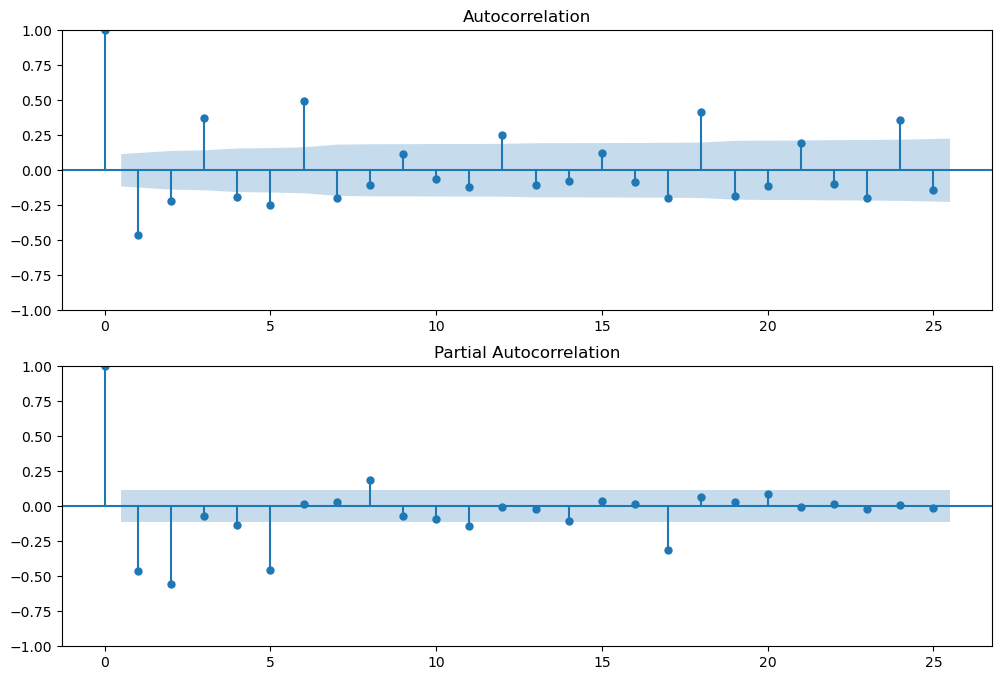

In [29]:
# Berechnung ACF und PACF (erste saisonale Differenz)
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(timeseries_df['GesamtBruttoleistung'].diff().dropna(), ax=ax[0])
plot_pacf(timeseries_df['GesamtBruttoleistung'].diff().dropna(), ax=ax[1])
plt.show()

**Ergebnisse:**     
p= 9   
q= 5   

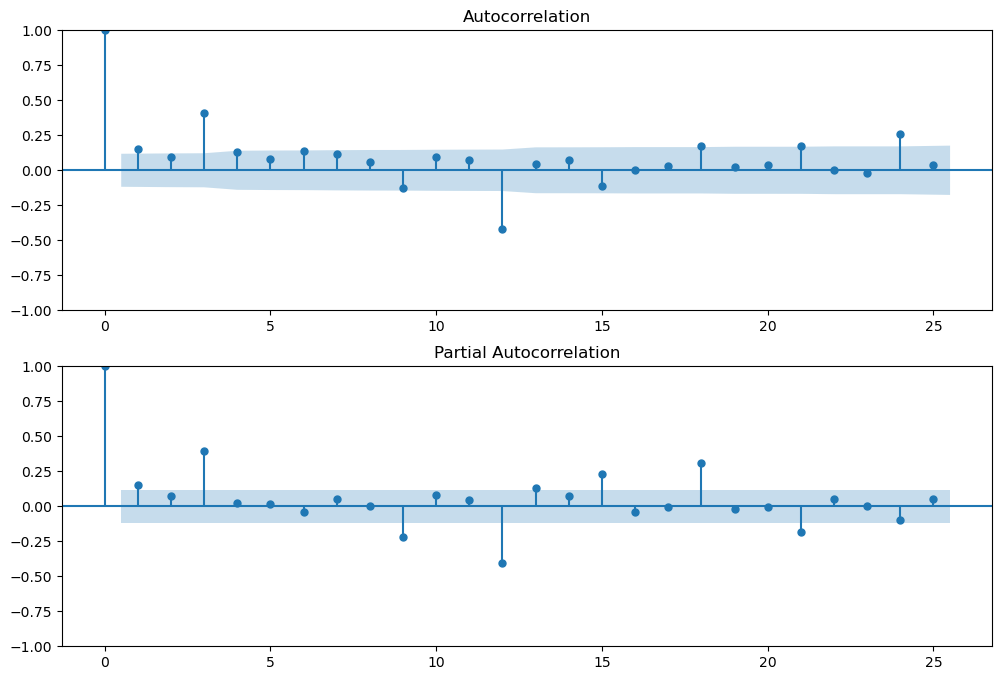

In [30]:
# Berechnung ACF und PACF (saisonale Differenz, 12 Monate)
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(timeseries_df['GesamtBruttoleistung'].diff(12).dropna(), ax=ax[0], lags=25) 
plot_pacf(timeseries_df['GesamtBruttoleistung'].diff(12).dropna(), ax=ax[1], lags=25)
plt.show()

**Ergebnisse:**    
P = 3    
Q = 7    

## Auswahl des Modells und der Variablen    
Quellen:    
https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH10/CH10_exercises_solution.ipynb 
https://datascientest.com/de/sarimax-modell-verstaendnis-und-anwendung-in-der-zeitreihenanalyse 
https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.fit.html

In [31]:
timeseries_df

,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,PV_Kosten_Euro_pro_kWp,Fukushima,Ukrainekrieg,Solardeckel
Jahr_Monat,,,,,,,,,
2000-01-01,42308.897,6944,2620,50.62,14.92,8100,0,0,0
2000-02-01,757.749,99,25,50.62,14.92,8100,0,0,0
2000-03-01,698.163,163,21,50.62,14.92,8100,0,0,0
2000-04-01,3479.965,871,153,50.62,14.92,8100,0,0,0
2000-05-01,3285.015,709,162,50.62,14.92,8100,0,0,0
...,...,...,...,...,...,...,...,...,...
2023-08-01,2304090.367,3807,98267,7.65,46.27,1250,0,0,0
2023-09-01,1358857.379,3443,89448,7.65,46.27,1250,0,0,0
2023-10-01,2101186.830,3008,77553,7.65,46.27,1250,0,0,0


In [32]:
# Daten normaliseren
scaler = MinMaxScaler()
columns_to_normalize = timeseries_df.columns[1:]
timeseries_df[columns_to_normalize] = scaler.fit_transform(timeseries_df[columns_to_normalize])
#timeseries_df

In [33]:
# Train/Test-Split
# Die letzten 14 Monate dienen als Testdaten zur Evaluation der Modelle.

test_size = 0.05
num_test = int(test_size * len(timeseries_df))

train_data = timeseries_df.iloc[:-num_test]
test_data = timeseries_df.iloc[-num_test:]

print("Trainingsdaten:", len(train_data))
print("Testdaten:", len(test_data))

Trainingsdaten: 274
Testdaten: 14


### Sarimax Modell, 1
**inkludiert alle Variablen**

In [34]:
def optimize_SARIMAX(endog, exog, order_list, d, D, s):
    results = []

    for order in order_list:
        try: 
            model = SARIMAX(
                endog,
                exog=exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False) 
        except Exception as e:
            print(f"An error occurred for order {order}: {e}")
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    # Sortiere aufsteigend, niedriger AIC ist besser
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [35]:
# Parameter
p = [7,8,9] 
d = 2  # Differenzierungen
q = [3,4,5] 
P = [2,3]  
D = 0  # Keine saisonale Differenzierung
Q = [5,6,7]  
s = 12 # 12 Monate

# Kombinationen der Parameter erstellen
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [36]:
target_train = train_data['GesamtBruttoleistung']
exog_train = train_data[['Anzahl_Volleinspeisung', 'Anzahl_Teileinspeisung', 'Einspeiseverguetung', 'Strompreis', 'PV_Kosten_Euro_pro_kWp', 'Fukushima', 'Ukrainekrieg', 'Solardeckel']]

# Zelle auskommentiert, da Berechnung sehr viel Zeit beansprucht.
#try:
#    result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
#    print(result_df)
#except Exception as e:
#    print(f"An error occurred while optimizing SARIMAX model: {e}")

Output (relevanter Ausschnitt)    
       (p,q,P,Q)          AIC   
0   (9, 5, 2, 7)  7078.592009   
1   (9, 5, 2, 5)  7082.504523   
2   (9, 4, 2, 7)  7085.670615       
3   (9, 5, 3, 5)  7085.694374      
4   (9, 4, 3, 7)  7086.681533         
5   (9, 4, 2, 6)  7087.502510       
6   (9, 3, 2, 7)  7087.629791       
7   (8, 4, 2, 7)  7087.719155          

**Bestes Modell:**    
p,q,P,Q: (9, 5, 2, 7)   
AIC: 7078.592009    
Der Akaike Information Criterion (AIC) schätzt die Qualität eines Modells und wird zur Modellauswahl verwendet. Da bei der Anpassung eines Modells an die Daten einige Informationen verloren gehen, quantifiziert der AIC die relative Menge der durch das Modell verlorenen Informationen. Je weniger Informationen verloren gehen, desto niedriger ist der AIC-Wert und desto besser ist das Modell. Die Auswahl nach dem AIC ermöglicht es uns, ein Gleichgewicht zwischen der Komplexität eines Modells und seiner Anpassungsfähigkeit an die Daten zu finden.    
(Time Series Forecasting in Python by Marco Peixeiro, S. 97ff)

In [37]:
model_1 = SARIMAX(target_train, exog=exog_train, order=(9, 2, 5), seasonal_order=(2, 0, 7, 12))
model_1_fit = model_1.fit(disp=False)
print(model_1_fit.summary())

C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

                                               SARIMAX Results                                                
Dep. Variable:                                   GesamtBruttoleistung   No. Observations:                  274
Model:             SARIMAX(9, 2, 5)x(2, 0, [1, 2, 3, 4, 5, 6, 7], 12)   Log Likelihood               -3698.050
Date:                                                Sun, 21 Apr 2024   AIC                           7460.101
Time:                                                        10:26:52   BIC                           7575.486
Sample:                                                    01-01-2000   HQIC                          7506.424
                                                         - 10-01-2022                                         
Covariance Type:                                                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------

**Ergebnisse:**  
Der Einfluss der exogenen Variablen in Zeitreihen kann durch Interpretation der Koeffizienten gemessen werden. Je höher der Betrag, desto höher ist der Einfluss der Variablen.     
    
Die wichtigsten Variablen sind *Anzahl_Teileinspeisung* und *Anzahl_Volleinspeisung*, was selbsterklärend ist. Je mehr Soalranlagen gebaut werden- in Voll- oder Teileinspeisung- desto höher ist die installierte Gesamtbruttoleistung.   
Das Modell misst diesen Variablen eine hohe Aussagekraft zu. Tatsächlich tragen sie jedoch nicht dazu bei, Einflussfaktoren zu erklären. Daher wird ein zweites Modell ohne diese Variablen trainiert.    

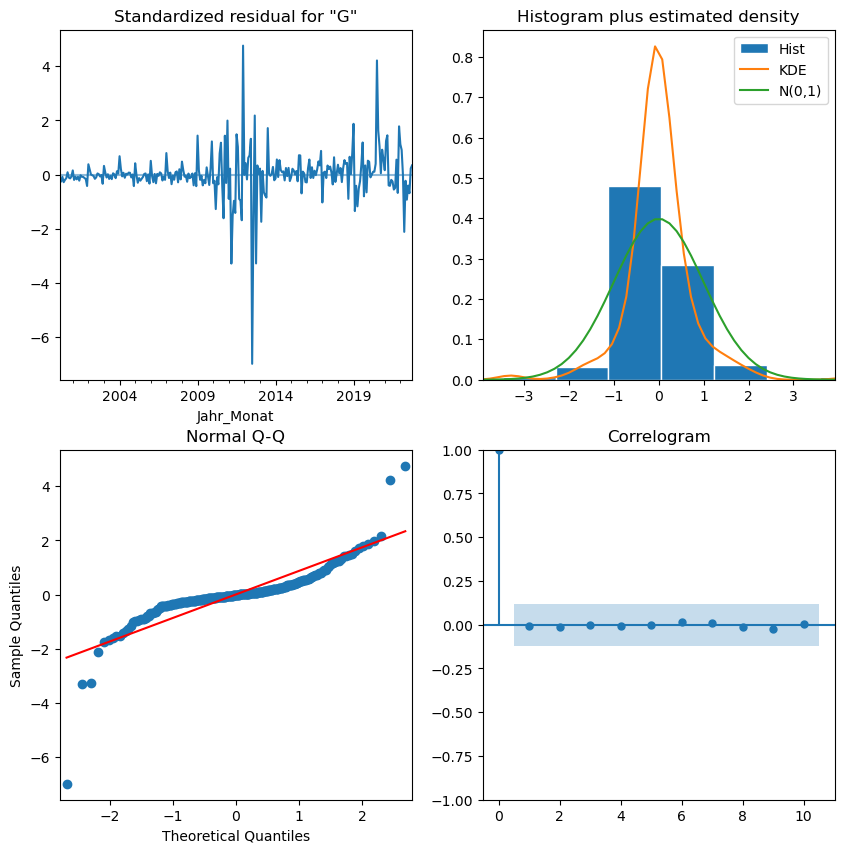

In [38]:
model_1_fit.plot_diagnostics(figsize=(10,10));

**Ergebnisse:**   
Ljung-Box-Test: 0,21   
Der p-Wert ist größer als 0,05. Das bedeuted, wir können die Nullhypothese, dass die Residuen unabhängig verteilt sind und somit keine Autokorrelation besteht, nicht zurückweisen.     
    
Standardized Residual Plot:   
Es gibt keinen erkennbaren Trend. Der Durchschnitt ist über die Zeit stabil, was auf Stationarität hinweist.    
    
Q-Q-Plot:    
Der Q-Q-Plot zeigt eine leicht geschwungene Linie, die sich jedoch nur wenig von der idealen geraden Linie entfernt. Das spricht dafür, dass die Residuen annähernd normal verteilt sind. Eine stark S-förmige Krümmung würde auf eine bimodale Verteilung hinweisen, was hier nicht gegeben ist.     
     
Histogram plus estimated density:   
Die KDE-Linie weicht deutlich von der grün dargestellten Normalverteilung ab. Die Verteilung ist jedoch stark auf den mittleren Bereich zentriert und schief. Es ist also auch hier eine gewisse Abweichung von der Normalverteilung erkennbar.    
    
Correlogram:   
Der einzige signifikante Peak ist bei 0 zu sehen. Das heißt, die Residuen sind nicht korreliert, was für ein gutes Modell spricht.    
(Time Series Forecasting in Python by Marco Peixeiro, S. 105f)

In [39]:
forecast_1 = model_1_fit.forecast(steps=len(test_data), exog=test_data[['Anzahl_Volleinspeisung', 'Anzahl_Teileinspeisung', 
                                                                    'Einspeiseverguetung','Strompreis', 'PV_Kosten_Euro_pro_kWp', 
                                                                    'Fukushima', 'Ukrainekrieg', 'Solardeckel']])

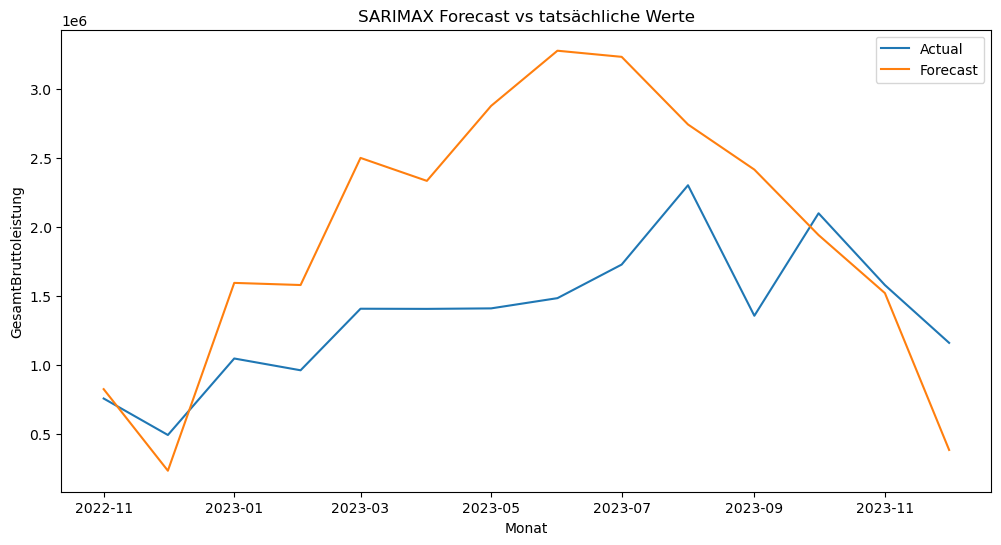

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['GesamtBruttoleistung'], label='Actual')
plt.plot(test_data.index, forecast_1, label='Forecast')
plt.title('SARIMAX Forecast vs tatsächliche Werte')
plt.xlabel('Monat')
plt.ylabel('GesamtBruttoleistung')
plt.legend()
plt.show()

### Sarimax, Modell 2   
**ohne die Variablen Anzahl_Teileinspeisung und Anzahl_Volleinspeisung**

In [41]:
target_train_2 = train_data['GesamtBruttoleistung']
exog_train_2 = train_data[['Einspeiseverguetung', 'Strompreis', 'PV_Kosten_Euro_pro_kWp', 'Fukushima', 'Ukrainekrieg', 'Solardeckel']]

# Zelle auskommentiert, da Berechnung sehr viel Zeit in Anspruch nimmt.
#try:
#    result_df_2 = optimize_SARIMAX(target_train_2, exog_train_2, parameters_list, d, D, s)
#    print(result_df_2)
#except Exception as e:
#    print(f"An error occurred while optimizing SARIMAX model: {e}")

Output (relevanter Ausschnitt):   
 (p,q,P,Q)          AIC     
0   (7, 3, 3, 5)  8021.204921   
1   (7, 3, 3, 6)  8021.618240   
2   (8, 3, 3, 6)  8023.326981   
3   (7, 3, 3, 7)  8023.446165   
4   (8, 3, 3, 5)  8023.757731   
5   (7, 3, 2, 5)  8026.098517   
6   (8, 3, 3, 7)  8026.478289   
7   (7, 3, 2, 7)  8027.057883   

Bestes Modell:   
p,q,P,Q: (7, 3, 3, 5)   
AIC: 8021.204921  

In [42]:
model_2 = SARIMAX(target_train_2, exog=exog_train_2, order=(7, 2, 3), seasonal_order=(3, 0, 5, 12))
model_2_fit = model_2.fit(disp=False)
print(model_2_fit.summary())

C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                            SARIMAX Results                                             
Dep. Variable:                             GesamtBruttoleistung   No. Observations:                  274
Model:             SARIMAX(7, 2, 3)x(3, 0, [1, 2, 3, 4, 5], 12)   Log Likelihood               -3985.602
Date:                                          Sun, 21 Apr 2024   AIC                           8021.205
Time:                                                  10:27:09   BIC                           8111.350
Sample:                                              01-01-2000   HQIC                          8057.395
                                                   - 10-01-2022                                         
Covariance Type:                                            opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

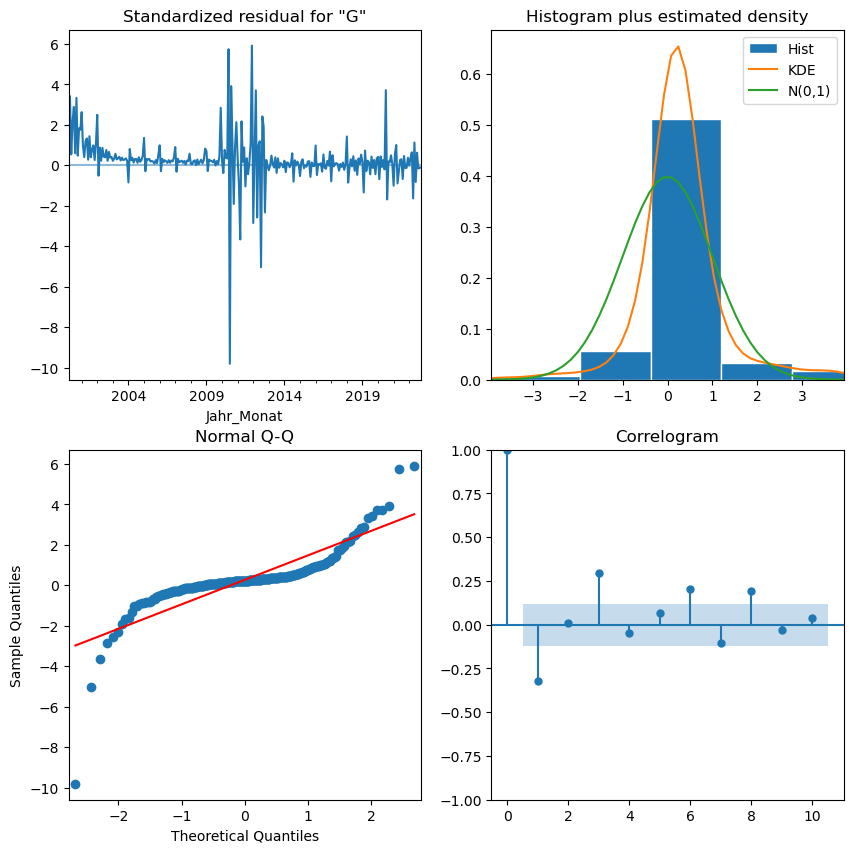

In [43]:
model_2_fit.plot_diagnostics(figsize=(10,10));

In [44]:
forecast_2 = model_2_fit.forecast(steps=len(test_data), exog=test_data[['Einspeiseverguetung','Strompreis', 'PV_Kosten_Euro_pro_kWp', 
                                                                    'Fukushima', 'Ukrainekrieg', 'Solardeckel']])

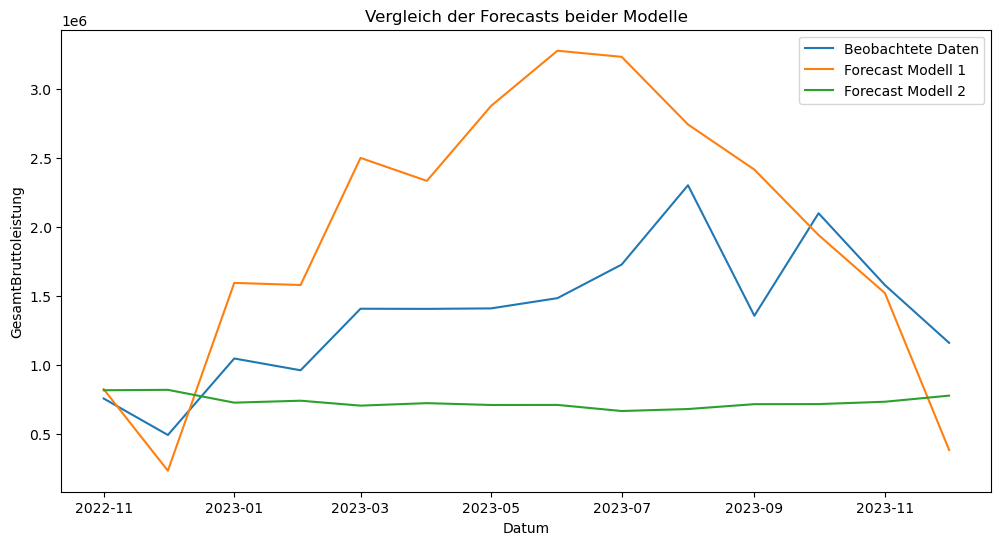

In [45]:
# Forecast für Modell 1
forecast_1 = model_1_fit.forecast(steps=len(test_data), exog=test_data[['Anzahl_Volleinspeisung', 'Anzahl_Teileinspeisung', 
                                                                    'Einspeiseverguetung','Strompreis', 'PV_Kosten_Euro_pro_kWp', 
                                                                    'Fukushima', 'Ukrainekrieg', 'Solardeckel']])

# Forecast für Modell 2
forecast_2 = model_2_fit.forecast(steps=len(test_data), exog=test_data[['Einspeiseverguetung','Strompreis', 'PV_Kosten_Euro_pro_kWp', 
                                                                    'Fukushima', 'Ukrainekrieg', 'Solardeckel']])

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['GesamtBruttoleistung'], label='Beobachtete Daten')
plt.plot(test_data.index, forecast_1, label='Forecast Modell 1')
plt.plot(test_data.index, forecast_2, label='Forecast Modell 2')
plt.xlabel('Datum')
plt.ylabel('GesamtBruttoleistung')
plt.title('Vergleich der Forecasts beider Modelle')
plt.legend()
plt.show()

### Sarimax, Modell 3
ohne die Ereignis-Variablen (Fukushima, Ukrainekrieg), Anzahl_Teileinspeisung und Anzahl_Volleinspeisung

In [46]:
target_train_3 = train_data['GesamtBruttoleistung']
exog_train_3 = train_data[['Einspeiseverguetung', 'Strompreis', 'PV_Kosten_Euro_pro_kWp', 'Solardeckel']]

# Zelle auskommentiert, da Berechnung sehr viel Zeit in Anspruch nimmt.
#try:
#    result_df_3 = optimize_SARIMAX(target_train_3, exog_train_3, parameters_list, d, D, s)
#    print(result_df_3)
#except Exception as e:
#    print(f"An error occurred while optimizing SARIMAX model: {e}")

Output (relevanter Ausschnitt):    
(p,q,P,Q)        AIC     
0   (7, 3, 3, 6)  8060.725986    
1   (8, 3, 3, 6)  8064.101830    
2   (7, 3, 3, 5)  8064.850520    
3   (9, 3, 3, 6)  8065.606868    
4   (8, 3, 3, 5)  8068.717085   
5   (9, 3, 2, 7)  8069.418274   
6   (9, 3, 3, 5)  8071.845881     

Bestes Modell:  
p,q,P,Q: (7, 3, 3, 6)   
AIC: 8060.725986   

In [47]:
model_3 = SARIMAX(target_train_3, exog=exog_train_3, order=(7, 2, 3), seasonal_order=(3, 0, 6, 12))
model_3_fit = model_3.fit(disp=False)
print(model_3_fit.summary())

C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

                                              SARIMAX Results                                              
Dep. Variable:                                GesamtBruttoleistung   No. Observations:                  274
Model:             SARIMAX(7, 2, 3)x(3, 0, [1, 2, 3, 4, 5, 6], 12)   Log Likelihood               -4006.363
Date:                                             Sun, 21 Apr 2024   AIC                           8060.726
Time:                                                     10:27:30   BIC                           8147.265
Sample:                                                 01-01-2000   HQIC                          8095.468
                                                      - 10-01-2022                                         
Covariance Type:                                               opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

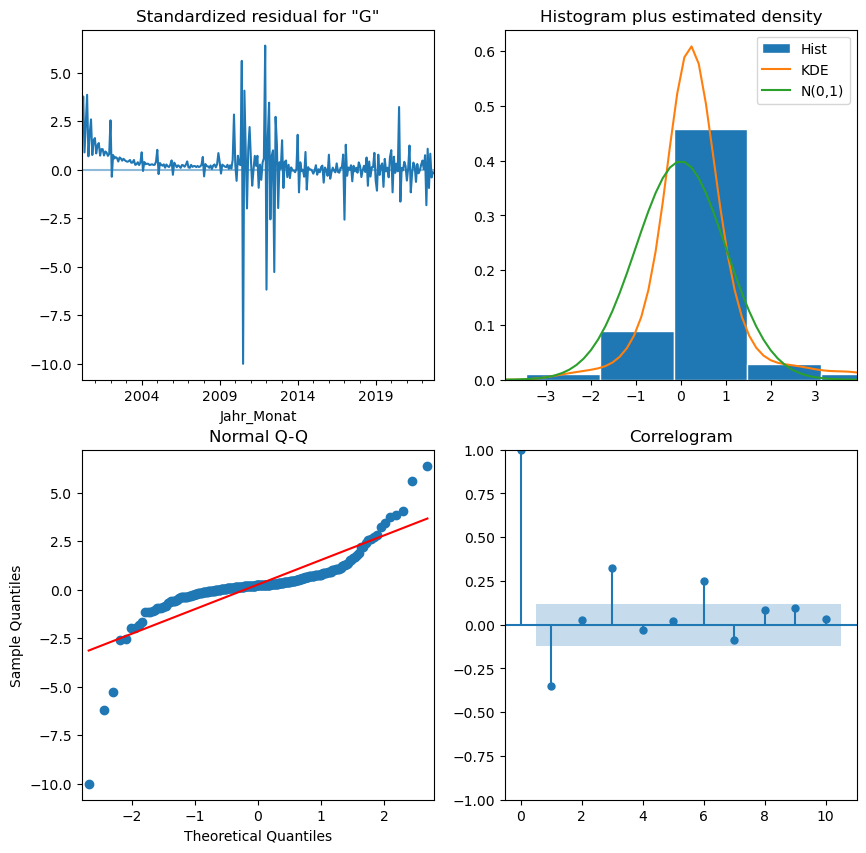

In [48]:
model_3_fit.plot_diagnostics(figsize=(10,10));

In [49]:
forecast_3 = model_3_fit.forecast(steps=len(test_data), exog=test_data[['Einspeiseverguetung','Strompreis', 'PV_Kosten_Euro_pro_kWp', 'Solardeckel']])

### Sarimax, Modell 4
ohne die Variablen Solardeckel, Fukushima, Ukrainekrieg, Anzahl_Teileinspeisung und Anzahl_Volleinspeisung

In [50]:
target_train_4 = train_data['GesamtBruttoleistung']
exog_train_4 = train_data[['Einspeiseverguetung', 'Strompreis', 'PV_Kosten_Euro_pro_kWp']]

# Zelle auskommentiert, da Berechnung sehr viel Zeit in Anspruch nimmt.
#try:
#    result_df_4 = optimize_SARIMAX(target_train_4, exog_train_4, parameters_list, d, D, s)
#    print(result_df_4)
#except Exception as e:
#    print(f"An error occurred while optimizing SARIMAX model: {e}")

Output (relevanter Ausschnitt):   
(p,q,P,Q) AIC   
0   (7, 3, 3, 6)  8100.284887    
1   (7, 3, 3, 7)  8103.298653    
2   (7, 3, 3, 5)  8105.601601   
3   (9, 3, 3, 6)  8105.618638   
4   (9, 3, 3, 7)  8107.995647   
5   (9, 3, 3, 5)  8110.651131    
6   (7, 3, 2, 5)  8116.641845   

Bestes Modell:   
p,q,P,Q: (7, 3, 3, 6)   
AIC: 8100.284887   

In [51]:
model_4 = SARIMAX(target_train_4, exog=exog_train_4, order=(7, 2, 3), seasonal_order=(3, 0, 6, 12))
model_4_fit = model_4.fit(disp=False)
print(model_4_fit.summary())

C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

                                              SARIMAX Results                                              
Dep. Variable:                                GesamtBruttoleistung   No. Observations:                  274
Model:             SARIMAX(7, 2, 3)x(3, 0, [1, 2, 3, 4, 5, 6], 12)   Log Likelihood               -4027.142
Date:                                             Sun, 21 Apr 2024   AIC                           8100.285
Time:                                                     10:27:50   BIC                           8183.218
Sample:                                                 01-01-2000   HQIC                          8133.580
                                                      - 10-01-2022                                         
Covariance Type:                                               opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

In [52]:
forecast_4 = model_4_fit.forecast(steps=len(test_data), exog=test_data[['Einspeiseverguetung','Strompreis', 'PV_Kosten_Euro_pro_kWp']])

## Vergleich der Sarimax-Modelle

### Vergleich der vorhergesagten mit den tatsächlichen Werten

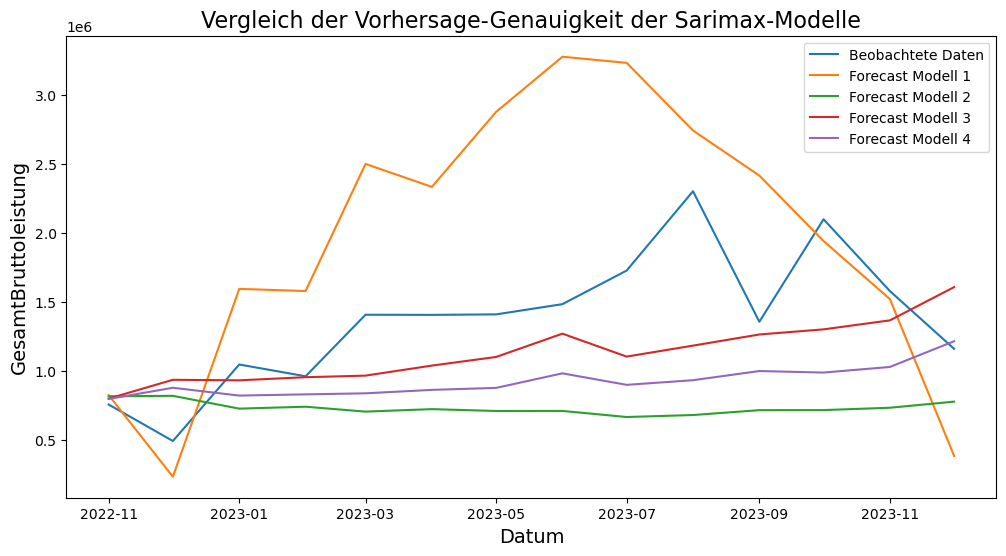

In [53]:
forecast_1 = model_1_fit.forecast(steps=len(test_data), exog=test_data[['Anzahl_Volleinspeisung', 'Anzahl_Teileinspeisung', 
                                                                    'Einspeiseverguetung','Strompreis', 'PV_Kosten_Euro_pro_kWp', 
                                                                    'Fukushima', 'Ukrainekrieg', 'Solardeckel']])

forecast_2 = model_2_fit.forecast(steps=len(test_data), exog=test_data[['Einspeiseverguetung','Strompreis', 'PV_Kosten_Euro_pro_kWp', 
                                                                    'Fukushima', 'Ukrainekrieg', 'Solardeckel']])

forecast_3 = model_3_fit.forecast(steps=len(test_data), exog=test_data[['Einspeiseverguetung','Strompreis', 'PV_Kosten_Euro_pro_kWp', 
                                                                    'Solardeckel']])

forecast_4 = model_4_fit.forecast(steps=len(test_data), exog=test_data[['Einspeiseverguetung','Strompreis', 'PV_Kosten_Euro_pro_kWp']])

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['GesamtBruttoleistung'], label='Beobachtete Daten')
plt.plot(test_data.index, forecast_1, label='Forecast Modell 1')
plt.plot(test_data.index, forecast_2, label='Forecast Modell 2')
plt.plot(test_data.index, forecast_3, label='Forecast Modell 3')
plt.plot(test_data.index, forecast_4, label='Forecast Modell 4')
plt.xlabel('Datum', fontsize=14)
plt.ylabel('GesamtBruttoleistung', fontsize=14)
plt.title('Vergleich der Vorhersage-Genauigkeit der Sarimax-Modelle', fontsize=16)
plt.legend()
plt.show()

**Ergebnisse:**  
    
Alle vier Modelle produzierten folgende Warnung:   
Warnings:    
[1] Covariance matrix calculated using the outer product of gradients (complex-step).    
[2] Covariance matrix is singular or near-singular, with condition number 5.87e+37. Standard errors may be unstable.   
Diese Warnungen sprechen dafür, dass die Modelle nicht robust sind und es möglicherweise Probleme mit Multikollinearität gibt.   

### Vergleich der Modelle anhand RMSE, MAPE und MAE

**Root Mean Squared Error (RMSE)**    
Der RMSE ist die Standardabweichung der Residuen (Vorhersagefehler). Residuen sind ein Maß dafür, wie weit die Datenpunkte von der Regressionslinie entfernt sind; RMSE ist ein Maß dafür, wie weit diese Residuen gestreut sind. Mit anderen Worten, er gibt an, wie konzentriert die Daten um die Linie der besten Anpassung sind.    
(https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/)    
     
**Mean Absolute Error (MAE)**        
Der absolute Fehler ist der Betrag des Fehlers in Ihren Messungen. Er ist die Differenz zwischen dem gemessenen Wert und dem "wahren" Wert.    
(https://www.statisticshowto.com/absolute-error/)      
    
**Mean Absolute Percentage Error (MAPE)**        
Der MAPE misst die Genauigkeit eines Prognosesystems in Prozent und kann als durchschnittlicher absoluter prozentualer Fehler für einen Zeitraum abzüglich der tatsächlichen Werte geteilt durch die     tatsächlichen Werte berechnet werden.    
(https://www.statisticshowto.com/mean-absolute-percentage-error-mape/)   

In [54]:
# Bewertung der Modelle anhand RMSE, MAPE und MAE
mse_model_1 = mean_squared_error(test_data['GesamtBruttoleistung'], forecast_1)
mse_model_2 = mean_squared_error(test_data['GesamtBruttoleistung'], forecast_2)
mse_model_3 = mean_squared_error(test_data['GesamtBruttoleistung'], forecast_3)
mse_model_4 = mean_squared_error(test_data['GesamtBruttoleistung'], forecast_4)
rmse_model_1 = np.sqrt(mse_model_1)
rmse_model_2 = np.sqrt(mse_model_2)
rmse_model_3 = np.sqrt(mse_model_3)
rmse_model_4 = np.sqrt(mse_model_4)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) * 100

mape_model_1 = mean_absolute_percentage_error(test_data['GesamtBruttoleistung'], forecast_1)
mape_model_2 = mean_absolute_percentage_error(test_data['GesamtBruttoleistung'], forecast_2)
mape_model_3 = mean_absolute_percentage_error(test_data['GesamtBruttoleistung'], forecast_3)
mape_model_4 = mean_absolute_percentage_error(test_data['GesamtBruttoleistung'], forecast_4)

model_results = {
    'Modell': ['Modell 1', 'Modell 2', 'Modell 3', 'Modell 4'],
    'RMSE': [rmse_model_1, rmse_model_2, rmse_model_3, rmse_model_4],
    'MAPE': [mape_model_1, mape_model_2, mape_model_3, mape_model_4],
    'MAE': [mean_absolute_error(test_data['GesamtBruttoleistung'], forecast_1),
            mean_absolute_error(test_data['GesamtBruttoleistung'], forecast_2),
            mean_absolute_error(test_data['GesamtBruttoleistung'], forecast_3),
            mean_absolute_error(test_data['GesamtBruttoleistung'], forecast_4)]
}
results_df = pd.DataFrame(model_results)
results_df

,Modell,RMSE,MAPE,MAE
0,Modell 1,940217.655049,0.576464,7.689138e+07
1,Modell 2,812418.184153,0.469980,6.939853e+07
2,Modell 3,478788.765972,0.272519,3.734282e+07
3,Modell 4,632189.569124,0.353165,5.140275e+07


In [55]:
# Verbindung zur Datenbank trennen
con.close()